In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [56]:
import tensorflow as tf

In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [52]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
SEQUENCE_LENGTH = 280
pad_token = '<PAD>'
EMBEDDING_DIM = 300

In [2]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [4]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [5]:
testData = testData.loc[testData["polarity"] != 2]

In [6]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [8]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [9]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [11]:
# !unzip drive/MyDrive/glove.42B.300d.zip
# !rm glove.42B.300d.zip

In [12]:
def load_embeddings(filename):
    labels = []
    rows = []
    result = {}
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
            result [items[0]] = values
    arr = np.vstack(rows)
    return result , arr
    # return pd.DataFrame(arr, index=labels, dtype='f')

embeddings, vectors = load_embeddings('glove.42B.300d.txt')


1917494it [03:50, 8305.40it/s]


In [27]:
average = np.mean(vectors , axis = 0)

In [28]:
# with open('average.pickle', 'rb') as f:
#     average = pickle.load(f)

In [29]:
# with open('embeddings.pickle', 'rb') as f:
#     embeddings = pickle.load(f)

In [30]:
# file = open('average.pickle','wb')
# pickle.dump(average, file)
# file.close()

In [31]:
# file = open('embeddings.pickle','wb')
# pickle.dump(embeddings, file)
# file.close()

In [32]:
len(embeddings)

1917494

In [33]:
# import pickle
# with open('saved_embeddings.pkl', 'wb') as f:
#     pickle.dump(embeddings, f)

In [34]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

In [35]:
def decode_sentiment(score):
  SENTIMENT_THRESHOLD = 0.5
  if score <= SENTIMENT_THRESHOLD:
      label = NEGATIVE
  elif score >= SENTIMENT_THRESHOLD:
      label = POSITIVE

  return label


In [36]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score )

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [37]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# def load_embeddings(filename):
#     labels = []
#     rows = []
#     with open(filename, encoding='utf-8') as infile:
#         for i, line in tqdm(enumerate(infile)):
#             items = line.rstrip().split(' ')
#             if len(items) == 2:
#                 # This is a header row giving the shape of the matrix
#                 continue
#             labels.append(items[0])
#             values = np.array([float(x) for x in items[1:]], 'f')
#             rows.append(values)
    
#     arr = np.vstack(rows)
#     return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('glove.42B.300d.txt')
# embeddings.shape

In [38]:
# embeddings.head()

In [39]:
(embeddings.get('the')).shape

(300,)

In [40]:
# testData.head()

In [41]:
# trainData.head()

In [42]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

In [43]:
testData.shape

(358, 2)

In [44]:
trainData.shape

(1599999, 2)

In [45]:
# ax = trainData.groupby('polarity').count().plot(kind='bar', title='Distribution of train data',
#                                                legend=False)
# ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [46]:
# ax = testData.groupby('polarity').count().plot(kind='bar', title='Distribution of test data',
#                                                legend=False)
# ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [47]:
text, sentiment = list(trainData['text']), list(trainData['polarity'])

In [48]:
test_text, test_sentiment = list(testData['text']), list(testData['polarity'])

In [49]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 200 seconds


In [53]:
t = time.time()
processed_test_text = preprocess(test_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


In [54]:
len(processedtext)

1599999

In [58]:
tokenizer = Tokenizer( )
tokenizer.fit_on_texts(processedtext)
# sequences = tokenizer.texts_to_sequences(processedtext)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)


Total words 249776


In [70]:
vocabulary =  tokenizer.word_index
print('Found %s unique tokens.' % len(vocabulary))

Found 249775 unique tokens.


In [59]:
x_train_ = pad_sequences(tokenizer.texts_to_sequences(processedtext), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(processed_test_text), maxlen=SEQUENCE_LENGTH)
y_test = test_sentiment

Word-Cloud for Negative tweets.

In [ ]:
# data_neg = processedtext[:800000]
# plt.figure(figsize = (20,20))
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.imshow(wc)

Word-Cloud for Positive tweets.


In [ ]:
# data_pos = processedtext[800000:]
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#               collocations=False).generate(" ".join(data_pos))
# plt.figure(figsize = (20,20))
# plt.imshow(wc)

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(x_train_, sentiment,test_size = 0.33, random_state = 42  )
print(f'Data Split done.')

Data Split done.


In [61]:
len(Y_validation)

528000

In [62]:
len(Y_train)

1071999

In [63]:
len(y_test)

358

In [64]:
x_test.shape

(358, 280)

In [66]:
x_train_.shape

(1599999, 280)

In [67]:
X_train.shape

(1071999, 280)

In [68]:
X_validation.shape

(528000, 280)

In [71]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM))

In [75]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = average


In [76]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.LSTM(150 , dropout = 0.2))
# model.add(tf.keras.layers.Dense(3, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]

model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 10

In [ ]:
history = model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1047/1047 [==============================] - 542s 512ms/step - loss: 0.4668 - accuracy: 0.7749 - precision: 0.7758 - recall: 0.7724 - val_loss: 0.4111 - val_accuracy: 0.8113 - val_precision: 0.8263 - val_recall: 0.7894 - lr: 0.0100
Epoch 2/10
1047/1047 [==============================] - 535s 511ms/step - loss: 0.4302 - accuracy: 0.7992 - precision: 0.8013 - recall: 0.7951 - val_loss: 0.4027 - val_accuracy: 0.8170 - val_precision: 0.8348 - val_recall: 0.7916 - lr: 0.0100
Epoch 3/10
1047/1047 [==============================] - 529s 506ms/step - loss: 0.4230 - accuracy: 0.8036 - precision: 0.8056 - recall: 0.7995 - val_loss: 0.3977 - val_accuracy: 0.8197 - val_precision: 0.8318 - val_recall: 0.8026 - lr: 0.0100
Epoch 4/10
1047/1047 [==============================] - 535s 511ms/step - loss: 0.4193 - accuracy: 0.8059 - precision: 0.8076 - recall: 0.8025 - val_loss: 0.3974 - val_accuracy: 0.8192 - val_precision: 0.8363 - val_recall: 0.7950 - lr: 0.0100
Epoch 5/10
1047/1047 [======

In [ ]:
model.save('unidirectional_lstm.h5')

In [ ]:
score = model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 0s 32ms/step - loss: 0.3611 - accuracy: 0.8352 - precision: 0.8280 - recall: 0.8508
ACCURACY: 0.8351955413818359
LOSS: 0.3611264228820801


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

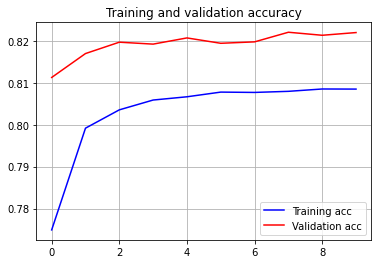

In [ ]:
plt.figure()
plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

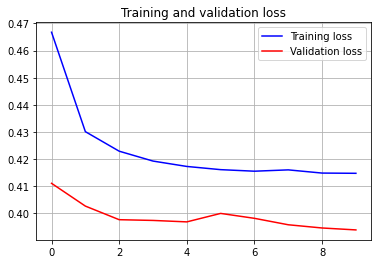

In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

12/12 [==============================] - 0s 21ms/step


<Figure size 432x432 with 0 Axes>

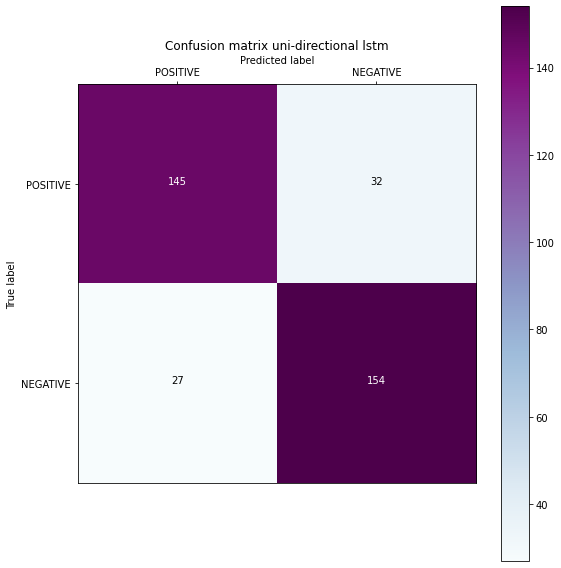

In [ ]:
y_pred_1d = []
y_test_1d = y_test
scores = model.predict(x_test, verbose=1)
# y_pred_1d = [decode_sentiment(score) for score in scores]
for score in scores:
  if score > 0.5:
    y_pred_1d.append(1)
  else:
    y_pred_1d.append(0)
cnf_matrix = tf.math.confusion_matrix(y_test_1d, y_pred_1d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix uni-directional lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test)):
  if y_pred_1d[i] == y_test_1d[i]:
    c+=1
print(c/len(y_test)*100)

bidirectionalLSTM


In [80]:
bi_model = tf.keras.models.Sequential()
bi_model.add(embedding_layer)
bi_model.add(tf.keras.layers.Dropout(0.5))
bi_model.add(tf.keras.layers.LSTM(150, dropout=0.2))
bi_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [88]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 10
BATCH_SIZE = 1024
bi_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [89]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [90]:
history2 = bi_model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1047/1047 [==============================] - 520s 491ms/step - loss: 0.4720 - accuracy: 0.7725 - precision: 0.7758 - recall: 0.7656 - val_loss: 0.4176 - val_accuracy: 0.8076 - val_precision: 0.8362 - val_recall: 0.7663 - lr: 0.0100
Epoch 2/10
1047/1047 [==============================] - 515s 492ms/step - loss: 0.4424 - accuracy: 0.7922 - precision: 0.7942 - recall: 0.7881 - val_loss: 0.4087 - val_accuracy: 0.8139 - val_precision: 0.8288 - val_recall: 0.7925 - lr: 0.0100
Epoch 3/10
1047/1047 [==============================] - 515s 492ms/step - loss: 0.4369 - accuracy: 0.7953 - precision: 0.7972 - recall: 0.7914 - val_loss: 0.4072 - val_accuracy: 0.8161 - val_precision: 0.8228 - val_recall: 0.8069 - lr: 0.0100
Epoch 4/10
1047/1047 [==============================] - 517s 494ms/step - loss: 0.4346 - accuracy: 0.7967 - precision: 0.7992 - recall: 0.7917 - val_loss: 0.4127 - val_accuracy: 0.8127 - val_precision: 0.8507 - val_recall: 0.7596 - lr: 0.0100
Epoch 5/10
1047/1047 [======

In [ ]:
model.save('bidirectional_lstm.h5')

In [ ]:
score = model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

In [ ]:
y_pred_2d = []
y_test_2d = Y_test
scores = model.predict(x_test, verbose=1)
# y_pred_1d = [decode_sentiment(score) for score in scores]
for score in scores:
  if score > 0.5:
    y_pred_1d.append(1)
  else:
    y_pred_1d.append(0)
cnf_matrix = tf.math.confusion_matrix(y_test_2d, y_pred_2d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix bidirectional lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test)):
  if y_pred_2d[i] == y_test_2d[i]:
    c+=1
print(c/len(y_test)*100)

83.5195530726257


In [ ]:
def lstm_cell(num_units, dropout, mode):
    cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

    dropout = dropout if mode == tf.estimator.ModeKeys.TRAIN else 0.0

    if dropout > 0.0:
        cell = tf.nn.rnn_cell.DropoutWrapper(
            cell=cell, input_keep_prob=(1.0 - dropout))

    return cell


In [ ]:
def lstm(inputs, sequence_length, num_units, dropout, mode):

    with tf.variable_scope('fw_cell'):
        forward_cell = lstm_cell(num_units, dropout, mode)
    # with tf.variable_scope('bw_cell'):
    #     backward_cell = lstm_cell(num_units, dropout, mode)

    return tf.nn.dynamic_rnn(
        forward_cell,
        inputs,
        sequence_length=sequence_length,
        dtype=tf.float32)


In [ ]:
def pyramidal_stack(outputs, sequence_length):
    shape = tf.shape(outputs)
    batch_size, max_time = shape[0], shape[1]
    num_units = outputs.get_shape().as_list()[-1]
    paddings = [[0, 0], [0, tf.floormod(max_time, 2)], [0, 0]]
    outputs = tf.pad(outputs, paddings)

    '''
    even_time = outputs[:, ::2, :]
    odd_time = outputs[:, 1::2, :]
    concat_outputs = tf.concat([even_time, odd_time], -1)
    '''

    concat_outputs = tf.reshape(outputs, (batch_size, -1, num_units * 2))

    return concat_outputs, tf.floordiv(sequence_length, 2) + tf.floormod(sequence_length, 2)


In [ ]:

def pyramidal_bilstm(inputs, sequence_length, mode, hparams):

    outputs = inputs

    for layer in range(4):
        with tf.variable_scope('lstm_{}'.format(layer)):
            outputs, state = lstm(outputs, sequence_length, hparams.num_units, hparams.dropout, mode)

            outputs = tf.concat(outputs, -1)

            if layer != 0:
                outputs, sequence_length = pyramidal_stack(
                    outputs, sequence_length)

    return (outputs, sequence_length), state

In [ ]:
   hparams = utils.create_hparams(
        args, vocab_size, utils.SOS_ID, utils.EOS_ID)

In [ ]:
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
# SENTIMENT_THRESHOLD = 0.5


In [ ]:
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"